In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
with open('authors.txt','r') as f:
    data = ['>'+line.strip()+'<' for line in f.readlines()]

(array([  1.00000000e+00,   0.00000000e+00,   1.14000000e+02,
          7.77000000e+02,   1.99800000e+03,   4.40300000e+03,
          6.01800000e+03,   7.29100000e+03,   7.59000000e+03,
          7.69000000e+03,   7.09400000e+03,   6.67000000e+03,
          5.62600000e+03,   4.80400000e+03,   4.09400000e+03,
          2.88500000e+03,   2.27300000e+03,   1.85400000e+03,
          1.60500000e+03,   1.58900000e+03]),
 array([  3.  ,   3.95,   4.9 ,   5.85,   6.8 ,   7.75,   8.7 ,   9.65,
         10.6 ,  11.55,  12.5 ,  13.45,  14.4 ,  15.35,  16.3 ,  17.25,
         18.2 ,  19.15,  20.1 ,  21.05,  22.  ]),
 <a list of 20 Patch objects>)

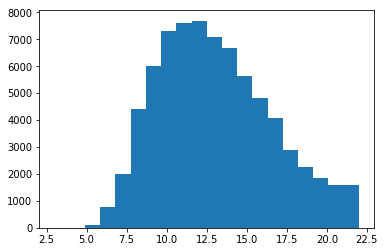

In [4]:
plt.hist([len(x) for x in data],bins = 20)

In [5]:
alphabet = list(set("".join(data)))

In [6]:
len(alphabet)

68

In [7]:
data[0]

'>silvery_silver<'

In [8]:
from torch import autograd

class Variable(autograd.Variable):
    def __init__(self, data, *args, **kwargs):
        data = data.cuda()
        super(Variable, self).__init__(data, *args, **kwargs)

In [9]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [10]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = alphabet.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

Variable containing:
  7
 50
 55
  5
 24
  4
[torch.LongTensor of size 6]



In [11]:
def random_training_set():    
    chunk = np.random.choice(data)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [12]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = alphabet[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [13]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(len(inp)):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / len(inp)

In [16]:
n_epochs = 10000
print_every = 2000
plot_every = 100
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(len(alphabet), hidden_size, len(alphabet), n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 5s (2000 20%) 2.4544]
Wheaxchedfmamnin<<<w<<9<<g<f<hert<f<<<<<Y<<rat<<<<r<<<<5<cicherenat<<<<<thFoty<<h<r<<<<<<<<<<<oMch<<co 

 9s (4000 40%) 2.8866]
Whise<h<<Rel<eDil<<l<elIw<le<<<<<OUSp<h<f<ols<<<<l<__eMard<<<un<e<<_Ya<<<<<_YOUU_YOSU<_YEo<<OY<<<<<<OU 

 17s (6000 60%) 3.0035]
Whillags<<<Div<A_dunt_Rir<ule<ro<r<<<<<<<<r<<<<t<on<<r<oBr<<<<<r<<<<<U<<o<<<<<i<<<<<ocu<o<<<<<<p<<EN<N 

 25s (8000 80%) 2.7072]
Whamt<u<or<li<<eDod<in_Sad<<ora<all<u<rle<<e<h<<<<<_<<M<<<<<<<<<<M<<<<<<<<<<<<<<<<F<BB<<<<TT<<o<F<<OT< 

 34s (10000 100%) 3.0213]
Wh<GOR_ROS<OR<OINORI_Skhr<ekt<<<<r<<<<a<<<<<<<<<<r<<<<<<<<<S<M<<<<<<<<ICThan<<<he<h<<<<<<<<<<<<<<<<<<< 



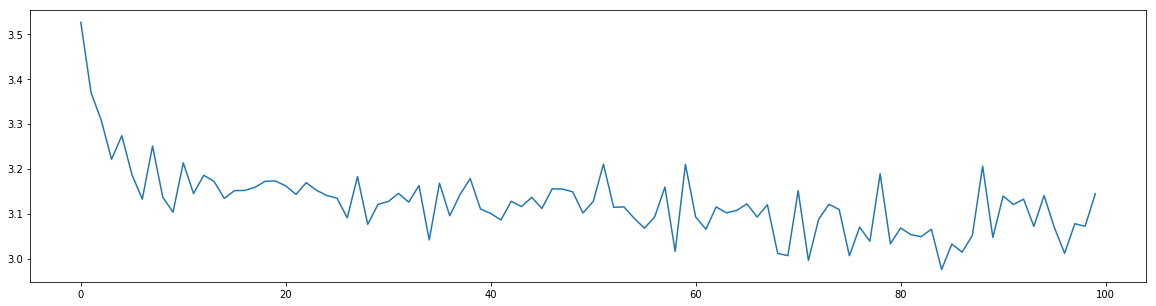

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure(figsize=(20,5))
plt.plot(all_losses)

In [29]:
for i in range(32):
    pure_output = evaluate('>put', 16, temperature=np.random.rand()*2)
    print("".join(list(next(iter(())) if ch == '<' else ch for ch in pure_output)))

/home/a/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: generator '<genexpr>' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


>puteloejou
>puthenethemer
>puterelly_
>putizal
>putaat
>puthonymyosu_u
>putstzo
>puttsonein
>putinnerrontincart
>putherthemens
>put_ps_zany
>puth_otone_m
>putetse7s
>putliculstlechs
>puter
>putotimgAjt
>puthiner
>putoro_yed1g
>putidybiUGyostB0bne
>puthwote
>puthethemer
>puthethertern
>putsoalthhu
>putunsoopuppounaodi
>puthoberty
>putur21117577
>putis
>put__bu72f
>putichly50961
>putbhpcbimjaninicop
>pute_hypkeiG_D
>putalgionpyjais
